In [15]:
import glob
import pandas as pd
#pip install datasets tensorflow
import numpy as np
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from PIL import Image
import io

In [2]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Folder path
folder_path = '/content/drive/MyDrive/final_cleaned_data/'  # change this

# Read all parquet files and concat
files = glob.glob(f'{folder_path}*.parquet')
df = pd.concat([pd.read_parquet(f) for f in files])

In [4]:
len(df)

85956

In [5]:
# replace all values to 0, only positive(3) is 1
df['Edema'] = df['Edema'].replace({1: 0, 2: 0, 3: 1})

In [6]:
df['Edema'].value_counts()

,count
Edema,
1,52246
0,33710


In [7]:
df.head()

,Sex,Age,Frontal/Lateral,Edema,image
0,0,68,0,1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,0,68,0,1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,0,68,1,1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,1,75,0,1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,0,85,0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [16]:
def gen():
  for i, row in df.iterrows():
    img_bytes = row['image']['bytes']
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB").resize((224, 224))
    img = tf.keras.utils.img_to_array(img) / 255.0
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    age = row['Age']
    sex = row['Sex']
    label = row['Edema']

    yield (img, age, sex), label

In [17]:
ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  #image
         tf.TensorSpec(shape=(), dtype=tf.float32),   #age
         tf.TensorSpec(shape=(), dtype=tf.float32)),  #sex
        tf.TensorSpec(shape=(), dtype=tf.int32)       #label
    )
).batch(32).repeat().prefetch(tf.data.AUTOTUNE)


In [18]:


# Image input
img_input = Input(shape=(224, 224, 3))
# Resnet
# resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=img_input)
# x = GlobalAveragePooling2D()(resnet.output)

# MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)
x = GlobalAveragePooling2D()(mobilenet.output)


# effnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_input)
# x = GlobalAveragePooling2D()(effnet.output)

# Age input
age_input = Input(shape=())
age_dense = Dense(16, activation='relu')(Reshape((1,))(age_input))

# Sex input
sex_input = Input(shape=())
sex_dense = Dense(8, activation='relu')(Reshape((1,))(sex_input))

# Merge
merged = Concatenate()([x, age_dense, sex_dense])
out = Dense(1, activation='sigmoid')(merged)

# Model
model = Model(inputs=[img_input, age_input, sex_input], outputs=out)


/tmp/ipython-input-18-2785773168.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,337 (8.62 MB)

 Trainable params: 2,225,225 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # multi-label
    metrics=['accuracy']
)

In [21]:
steps = len(df) // 32

In [22]:
model.fit(
    ds,
    epochs=3,
    steps_per_epoch=steps,
    batch_size=32,
    verbose=1
)

Epoch 1/3
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 735s 255ms/step - accuracy: 0.7198 - loss: 0.5805
Epoch 2/3
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 705s 255ms/step - accuracy: 0.7356 - loss: 0.5524
Epoch 3/3
2686/2686 ━━━━━━━━━━━━━━━━━━━━ 684s 255ms/step - accuracy: 0.7358 - loss: 0.5551


In [33]:
# Get one batch from dataset
(X_img, X_age, X_sex), y = next(iter(ds))

# Predict
preds = model.predict((X_img, X_age, X_sex))

# Binary output
pred_labels = (preds > 0.5).astype(int)

# Show result
print("Predicted:", pred_labels[0][0])
print("True:", y[0].numpy())

# Print first 10
for i in range(10):
    print(f"Sample {i+1}: Predicted = {pred_labels[i][0]}, True = {y[i].numpy()}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicted: 0
True: 0
Sample 1: Predicted = 0, True = 0
Sample 2: Predicted = 0, True = 0
Sample 3: Predicted = 0, True = 0
Sample 4: Predicted = 0, True = 1
Sample 5: Predicted = 0, True = 0
Sample 6: Predicted = 0, True = 0
Sample 7: Predicted = 0, True = 0
Sample 8: Predicted = 0, True = 0
Sample 9: Predicted = 0, True = 0
Sample 10: Predicted = 0, True = 0


In [34]:
val_df = pd.read_parquet('/content/validation-00000-of-00001.parquet')
# select only necessary columns
val_df = val_df[['Sex', 'Age', 'Frontal/Lateral', 'Edema', 'image']]

In [35]:
val_df['Edema'] = val_df['Edema'].replace({1: 0, 2: 0, 3: 1})

In [36]:
val_df['Edema'].value_counts()

,count
Edema,
0,189
1,45


In [41]:
import numpy as np
import tensorflow as tf
from PIL import Image
import io

X_img, X_age, X_sex, y_true = [], [], [], []

for _, row in df.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes'])).convert("RGB").resize((224, 224))
    img = tf.keras.utils.img_to_array(img) / 255.0
    X_img.append(img)

    X_age.append(row['Age'])
    X_sex.append(row['Sex'])
    y_true.append(row['Edema'])

# Convert to tensors
X_img = tf.convert_to_tensor(np.array(X_img), dtype=tf.float32)
X_age = tf.convert_to_tensor(np.array(X_age), dtype=tf.float32)
X_sex = tf.convert_to_tensor(np.array(X_sex), dtype=tf.float32)
y_true = tf.convert_to_tensor(np.array(y_true), dtype=tf.int32)


In [45]:
preds = model.predict((X_img, X_age, X_sex), batch_size=len(X_img))
pred_labels = (preds > 0.3).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


In [46]:
for i in range(len(y_true)):
    print(f"Sample {i+1}: Predicted = {pred_labels[i][0]}, True = {y_true[i].numpy()}")


Sample 1: Predicted = 0, True = 0
Sample 2: Predicted = 0, True = 0
Sample 3: Predicted = 0, True = 0
Sample 4: Predicted = 0, True = 1
Sample 5: Predicted = 0, True = 0
Sample 6: Predicted = 0, True = 0
Sample 7: Predicted = 0, True = 0
Sample 8: Predicted = 0, True = 0
Sample 9: Predicted = 0, True = 0
Sample 10: Predicted = 0, True = 0
Sample 11: Predicted = 0, True = 0
Sample 12: Predicted = 0, True = 0
Sample 13: Predicted = 0, True = 0
Sample 14: Predicted = 0, True = 0
Sample 15: Predicted = 0, True = 0
Sample 16: Predicted = 1, True = 1
Sample 17: Predicted = 0, True = 0
Sample 18: Predicted = 0, True = 0
Sample 19: Predicted = 0, True = 1
Sample 20: Predicted = 0, True = 0
Sample 21: Predicted = 0, True = 0
Sample 22: Predicted = 0, True = 1
Sample 23: Predicted = 0, True = 0
Sample 24: Predicted = 0, True = 0
Sample 25: Predicted = 0, True = 0
Sample 26: Predicted = 0, True = 0
Sample 27: Predicted = 0, True = 0
Sample 28: Predicted = 0, True = 0
Sample 29: Predicted = 0, Tru

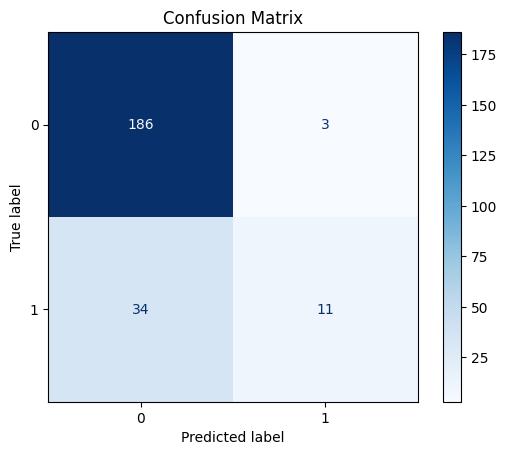

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true_np = y_true.numpy().flatten()

cm = confusion_matrix(y_true_np, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [52]:
model.save("chest_xray_model_temp.h5")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=chest_xray_model_temp.

In [49]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [50]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Load model
model = tf.keras.models.load_model("chest_xray_model_temp.h5", compile=False)

# Title
st.title("Edema Detection from Chest X-ray")

# Input: Image
uploaded_file = st.file_uploader("Upload Chest X-ray", type=["jpg", "png", "jpeg"])
age = st.number_input("Age", min_value=0)
sex = st.selectbox("Sex", options=["Male", "Female"])
view = st.selectbox("View Position", options=["Frontal", "Lateral"])

if uploaded_file:
    img = Image.open(uploaded_file).convert("RGB").resize((224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Process inputs
    age_tensor = tf.convert_to_tensor(float(age), dtype=tf.float32)
    sex_val = 0.0 if sex == "Male" else 1.0
    sex_tensor = tf.convert_to_tensor(sex_val, dtype=tf.float32)

    # Add batch dim
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    age_tensor = tf.expand_dims(age_tensor, axis=0)
    sex_tensor = tf.expand_dims(sex_tensor, axis=0)

    # Prediction
    pred = model.predict((img_tensor, age_tensor, sex_tensor))[0][0]
    result = "Edema Detected" if pred > 0.5 else "No Edema"

    st.image(img, caption="Uploaded Image", use_column_width=True)
    st.markdown(f"### Prediction: **{result}** (Confidence: {pred:.2f})")


2025-07-30 10:23:08.654 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 10:23:08.770 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-30 10:23:08.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 10:23:08.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 10:23:08.774 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 10:23:08.775 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 10:23:08.777 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 10:23:08.778 Thread 'MainThread': mi

In [53]:
print(tf.__version__)

2.18.0
